In [141]:
import numpy as np
import pandas as pd
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing



import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
plt.style.use('ggplot')

In [8]:
dataset = pd.read_csv('data/generated/master_data.csv')
dataset.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,...,away_Long_Shots,away_Aggression,away_Penalties,away_Marking,away_Standing_Tackle,away_goal_mean,away_goals_with_home,goal_diff_with_away,home_goal_mean,home_goals_with_away
39350,2018-06-04,Italy,Netherlands,1,1,Friendly,Turin,Italy,False,2018,...,79.100000,80.8,84.333333,83.000000,83.4,1.914894,1.00,7,1.530612,1.35
39351,2018-06-04,Serbia,Chile,0,1,Friendly,Graz,Austria,True,2018,...,79.500000,85.0,82.000000,76.333333,80.8,1.574074,1.00,2,1.361111,3.00
39352,2018-06-04,Slovakia,Morocco,1,2,Friendly,Geneva,Switzerland,True,2018,...,75.700000,80.8,79.000000,81.333333,78.4,1.659574,2.00,-1,1.575000,1.00
39353,2018-06-04,Armenia,Moldova,0,0,Friendly,Kematen,Austria,True,2018,...,42.975000,72.2,61.333333,73.333333,73.6,0.486486,1.75,-2,1.250000,1.25
39354,2018-06-04,India,Kenya,3,0,Friendly,Mumbai,India,False,2018,...,46.671429,73.2,57.666667,68.000000,63.2,0.911111,0.00,0,1.870968,0.00


In [16]:
print("Dataset length", dataset.shape[0])
dataset = dataset.dropna()
print("Dataset complete cases length", dataset.shape[0])

Dataset length 39355
Dataset complete cases length 6688


In [17]:
dataset.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'year',
       ...
       'sprint_speed_diff', 'reactions_diff', 'shot_power_diff',
       'stamina_diff', 'strength_diff', 'long_shots_diff', 'aggression_diff',
       'penalties_diff', 'marking_diff', 'standing_tackle_diff'],
      dtype='object', length=107)

In [18]:
dataset["home_win"] = np.sign(dataset["home_score"] - dataset["away_score"])
dataset["elo_diff"] = dataset["home_elo"] - dataset["away_elo"]
dataset["rating_diff"] = dataset["home_overall_rating_avg"] - dataset["away_overall_rating_avg"]
dataset["potential_diff"] = dataset["home_potential_avg"] - dataset["away_potential_avg"]
dataset["height_diff"] = dataset["home_height"] - dataset["away_height"]
dataset["weight_diff"] = dataset["home_weight"] - dataset["away_weight"]
dataset["age_diff"] = dataset["home_age"] - dataset["away_age"]
dataset["weak_foot_diff"] = dataset["home_weak_foot"] - dataset["away_weak_foot"]
dataset["internationl_repuatiotion_diff"] = dataset["home_international_reputation"] - dataset["away_international_reputation"]
dataset["crossing_diff"] = dataset["home_Crossing"] - dataset["away_Crossing"]
dataset["finishing_diff"] = dataset["home_Finishing"] - dataset["away_Finishing"]
dataset["heading_accuracy_diff"] = dataset["home_Heading_Accuracy"] - dataset["away_Heading_Accuracy"]
dataset["short_passing_diff"] = dataset["home_Short_Passing"] - dataset["away_Short_Passing"]
dataset["dribbling_diff"] = dataset["home_Dribbling"] - dataset["away_Dribbling"]
dataset["fk_accuracy_diff"] = dataset["home_FK_Accuracy"] - dataset["away_FK_Accuracy"]
dataset["long_passing_diff"] = dataset["home_Long_Passing"] - dataset["away_Long_Passing"]
dataset["ball_control_diff"] = dataset["home_Ball_Control"] - dataset["away_Ball_Control"]
dataset["acceleration_diff"] = dataset["home_Acceleration"] - dataset["away_Acceleration"]
dataset["sprint_speed_diff"] = dataset["home_Sprint_Speed"] - dataset["away_Sprint_Speed"]
dataset["reactions_diff"] = dataset["home_Reactions"] - dataset["away_Reactions"]
dataset["shot_power_diff"] = dataset["home_Shot_Power"] - dataset["away_Shot_Power"]
dataset["stamina_diff"] = dataset["home_Stamina"] - dataset["away_Stamina"]
dataset["strength_diff"] = dataset["home_Strength"] - dataset["away_Strength"]
dataset["long_shots_diff"] = dataset["home_Long_Shots"] - dataset["away_Long_Shots"]
dataset["aggression_diff"] = dataset["home_Aggression"] - dataset["away_Aggression"]
dataset["penalties_diff"] = dataset["home_Penalties"] - dataset["away_Penalties"]
dataset["marking_diff"] = dataset["home_Marking"] - dataset["away_Marking"]
dataset["standing_tackle_diff"] = dataset["home_Standing_Tackle"] - dataset["away_Standing_Tackle"]

In [19]:
feature_columns = ["elo_diff", "rating_diff", "potential_diff",
                   "height_diff", "weight_diff", "age_diff", "weak_foot_diff",
                   "internationl_repuatiotion_diff", "crossing_diff", "finishing_diff", "heading_accuracy_diff",
                   "short_passing_diff", "dribbling_diff", "fk_accuracy_diff", "long_passing_diff",
                   'ball_control_diff', 'acceleration_diff', 'sprint_speed_diff', "reactions_diff",
                   'shot_power_diff', 'stamina_diff', 'strength_diff', 'long_shots_diff',
                   "aggression_diff", "penalties_diff", "marking_diff", "standing_tackle_diff",
                   "away_goal_mean", "away_goals_with_home", "goal_diff_with_away", "home_goal_mean",
                   "home_goals_with_away"]

wtl_col = "home_win"

In [232]:
no_friendly_or_wc = dataset[(dataset["tournament"] != "Friendly") & (dataset["tournament"] != "FIFA World Cup")]
print("No friendly or WC games length: ", no_friendly_or_wc.shape[0])

X = no_friendly_or_wc[feature_columns]
y = no_friendly_or_wc[wtl_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("No friendly games train set length: ", X_train.shape[0])

friendly_games = dataset[dataset["tournament"] == "Friendly"]
print("Friendly games length: ", friendly_games.shape[0])
X_friendly = friendly_games[feature_columns]
y_friendly = friendly_games[wtl_col]

X_train = pd.concat([X_train, X_friendly])
y_train = pd.concat([y_train, y_friendly])

wc_games = dataset[dataset["tournament"] == "FIFA World Cup"]
print("WC games length: ", wc_games.shape[0])
X_wc = wc_games[feature_columns]
y_wc = wc_games[wtl_col]
X_test = pd.concat([X_test, X_wc])
y_test = pd.concat([y_test, y_wc])

print("Whole train set length: ", X_train.shape[0])
print("Whole test set length: ", X_test.shape[0])
print("Train set width: ", X_train.shape[1])

No friendly or WC games length:  3790
No friendly games train set length:  2842
Friendly games length:  2770
WC games length:  128
Whole train set length:  5612
Whole test set length:  1076
Train set width:  32


In [229]:
no_friendly_or_wc

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,...,sprint_speed_diff,reactions_diff,shot_power_diff,stamina_diff,strength_diff,long_shots_diff,aggression_diff,penalties_diff,marking_diff,standing_tackle_diff
32005,2010-06-11,South Africa,Mexico,1,1,FIFA World Cup,Johannesburg,South Africa,False,2010,...,0.333333,-2.20,-3.80,0.000000,-0.900000,-8.400000,-3.2,-5.333333,-6.333333,-3.60
32006,2010-06-11,Uruguay,France,0,0,FIFA World Cup,Cape Town,South Africa,True,2010,...,-5.333333,-3.20,-3.80,-5.800000,-0.300000,-0.900000,-0.4,-7.666667,-2.333333,-8.60
32007,2010-06-12,Argentina,Nigeria,1,0,FIFA World Cup,Johannesburg,South Africa,True,2010,...,-1.666667,8.40,1.40,5.300000,-0.800000,9.900000,4.6,7.000000,7.333333,10.80
32008,2010-06-12,England,United States,1,1,FIFA World Cup,Rustenburg,South Africa,True,2010,...,6.666667,8.20,8.80,6.400000,5.900000,15.700000,8.0,9.333333,11.000000,12.00
32009,2010-06-12,Korea Republic,Greece,2,0,FIFA World Cup,Port Elizabeth,South Africa,True,2010,...,-4.666667,0.80,-5.00,1.200000,-7.600000,-8.800000,1.8,1.333333,-3.000000,-7.80
32010,2010-06-13,Algeria,Slovenia,0,1,FIFA World Cup,Polokwane,South Africa,True,2010,...,8.000000,-2.00,-2.40,-0.300000,-2.000000,-3.100000,2.2,-4.333333,4.000000,2.60
32011,2010-06-13,Germany,Australia,4,0,FIFA World Cup,Durban,South Africa,True,2010,...,4.666667,7.40,9.20,1.200000,1.800000,9.800000,-1.6,2.000000,12.333333,8.20
32012,2010-06-13,Serbia,Ghana,0,1,FIFA World Cup,Pretoria,South Africa,True,2010,...,1.000000,-1.20,0.20,-5.600000,-0.100000,6.700000,-2.2,-2.000000,1.666667,3.00
32013,2010-06-14,Italy,Paraguay,1,1,FIFA World Cup,Cape Town,South Africa,True,2010,...,6.666667,7.60,6.20,5.200000,3.200000,13.600000,7.2,16.000000,7.333333,8.60
32014,2010-06-14,Japan,Cameroon,1,0,FIFA World Cup,Bloemfontein,South Africa,True,2010,...,-6.666667,-4.60,-5.00,-11.300000,-19.000000,-7.800000,-17.2,-4.333333,-11.333333,-17.80


<Figure size 1440x432 with 0 Axes>

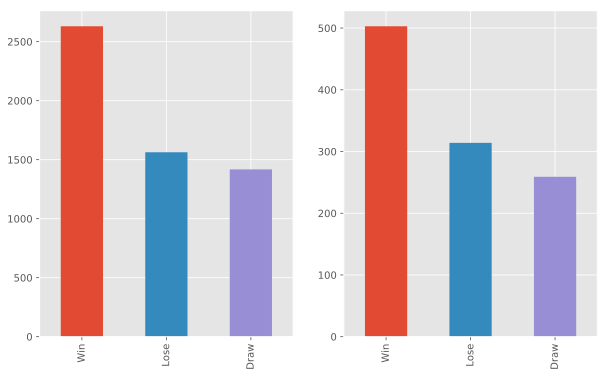

In [234]:
def get_labeled_df(s):
    df = pd.DataFrame(s)
    df[df["home_win"] == 1] = "Win"
    df[df["home_win"] == 0] = "Draw"
    df[df["home_win"] == -1] = "Lose"
    return df

plt.figure(figsize=(20, 6))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
pd.value_counts(get_labeled_df(y_train)["home_win"]).plot.bar(ax=axes[0])
pd.value_counts(get_labeled_df(y_test)["home_win"]).plot.bar(ax=axes[1])

,elo_diff,rating_diff,potential_diff,height_diff,weight_diff,age_diff,weak_foot_diff,internationl_repuatiotion_diff,crossing_diff,finishing_diff,...,long_shots_diff,aggression_diff,penalties_diff,marking_diff,standing_tackle_diff,away_goal_mean,away_goals_with_home,goal_diff_with_away,home_goal_mean,home_goals_with_away
elo_diff,1.000000,0.758235,0.752713,0.511147,0.418156,0.432521,0.443387,0.702953,0.684533,0.668083,...,0.684931,0.579420,0.657655,0.568863,0.585646,-0.483885,-0.453929,0.369604,0.491934,0.446879
rating_diff,0.758235,1.000000,0.972061,0.736373,0.623155,0.661346,0.550506,0.765358,0.758271,0.755258,...,0.821641,0.729490,0.740335,0.668061,0.714018,-0.368720,-0.401243,0.339336,0.381886,0.406074
potential_diff,0.752713,0.972061,1.000000,0.748875,0.617662,0.560082,0.542899,0.749661,0.755665,0.746427,...,0.806122,0.721877,0.734546,0.666678,0.715527,-0.358373,-0.397558,0.342711,0.378586,0.414049
height_diff,0.511147,0.736373,0.748875,1.000000,0.894721,0.654357,0.480826,0.458381,0.594965,0.618562,...,0.643420,0.660272,0.599110,0.603930,0.653346,-0.232655,-0.296293,0.207233,0.247771,0.286708
weight_diff,0.418156,0.623155,0.617662,0.894721,1.000000,0.591127,0.354311,0.384486,0.436262,0.500409,...,0.510339,0.578372,0.495685,0.514172,0.556471,-0.196225,-0.245807,0.157255,0.196304,0.225286
age_diff,0.432521,0.661346,0.560082,0.654357,0.591127,1.000000,0.435515,0.449613,0.541672,0.532190,...,0.583475,0.566537,0.530088,0.519955,0.554053,-0.216123,-0.257193,0.163921,0.187954,0.208366
weak_foot_diff,0.443387,0.550506,0.542899,0.480826,0.354311,0.435515,1.000000,0.390888,0.554004,0.533904,...,0.578015,0.430010,0.530542,0.419062,0.455782,-0.254947,-0.240639,0.169145,0.263153,0.217172
internationl_repuatiotion_diff,0.702953,0.765358,0.749661,0.458381,0.384486,0.449613,0.390888,1.000000,0.581912,0.574647,...,0.601417,0.493029,0.561063,0.496894,0.537484,-0.359755,-0.370188,0.368395,0.397198,0.380851
crossing_diff,0.684533,0.758271,0.755665,0.594965,0.436262,0.541672,0.554004,0.581912,1.000000,0.871156,...,0.856764,0.790283,0.839786,0.774995,0.784589,-0.323249,-0.362058,0.297247,0.342293,0.392238
finishing_diff,0.668083,0.755258,0.746427,0.618562,0.500409,0.532190,0.533904,0.574647,0.871156,1.000000,...,0.894060,0.740904,0.869393,0.647959,0.656553,-0.316178,-0.358224,0.279800,0.332357,0.378459


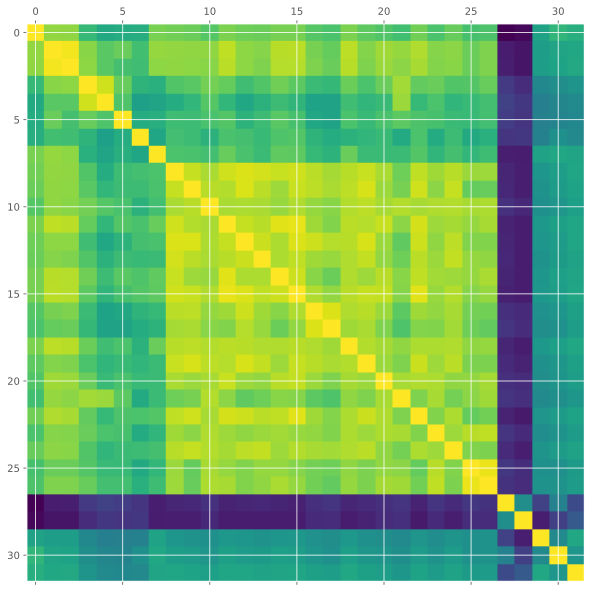

In [91]:
plt.figure(figsize=(10,10))
plt.matshow(X_train.corr(), fignum=1)
X_train.corr()

In [122]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [124]:
def get_feature_importance(clf):
    zipped = sorted(zip(feature_columns, clf.feature_importances_), key = lambda t: t[1], reverse=True)
    for feature, importance in zipped:
        print(f"{feature}: {importance}")

In [237]:
def run_random_search(clf, param_dist, 
                      Xtrain, ytrain, 
                      Xtest, ytest, 
                      X_wc, y_wc,
                      n_iter_search=60, custom_report_for_model=None, 
                      preprocess=False):
    
    if preprocess:
        scaler = preprocessing.StandardScaler().fit(Xtrain)
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search)
    start = time()
    random_search.fit(Xtrain, ytrain)
    print("TRAIN SET METRICS:")
    print("SCORE: ", random_search.score(Xtrain, ytrain))
    y_true, y_pred = ytrain, random_search.predict(Xtrain)
    print(classification_report(y_true, y_pred))
    print("BEST PARAMS: ", random_search.best_params_)
    print()
    print()
    
    best_clf = random_search.best_estimator_
    best_clf.fit(Xtrain, ytrain)
    
    print("TEST SET METRICS:")
    print("SCORE: ", best_clf.score(Xtest, ytest))
    y_true, y_pred = ytest, best_clf.predict(Xtest)
    print("\n",classification_report(y_true, y_pred))
        
    print()
    print()
    print("WC SET METRICS:")
    print("SCORE: ", random_search.score(X_wc, y_wc))
    y_true, y_pred = y_wc, best_clf.predict(X_wc)
    print("\n",classification_report(y_true, y_pred))
    
    print()
    print()
    if custom_report_for_model:
        custom_report_for_model(best_clf)

In [238]:
clf = RandomForestClassifier(oob_score=False, n_jobs=-1)

param_dist = {"n_estimators": [700],
              "max_depth": [None],
              "min_samples_leaf": sp_randint(1, 20),
              "max_features": ["sqrt"],
              "bootstrap": [True],
              "criterion": ["gini"]}
run_random_search(clf, param_dist,
                  X_train, y_train, 
                  X_test, y_test, 
                  X_wc, y_wc,
                  custom_report_for_model=get_feature_importance, 
                  preprocess=False, n_iter_search=20)

TRAIN SET METRICS:
SCORE:  0.817177476835
             precision    recall  f1-score   support

         -1       0.80      0.83      0.82      1563
          0       0.99      0.57      0.72      1418
          1       0.78      0.94      0.86      2631

avg / total       0.84      0.82      0.81      5612

BEST PARAMS:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'n_estimators': 700}


TEST SET METRICS:
SCORE:  0.635687732342

              precision    recall  f1-score   support

         -1       0.61      0.75      0.67       314
          0       0.47      0.08      0.13       259
          1       0.67      0.85      0.75       503

avg / total       0.60      0.64      0.58      1076

elo_diff: 0.22099315760443505
potential_diff: 0.04203235825212237
rating_diff: 0.03995258150140614
crossing_diff: 0.03949752526217089
reactions_diff: 0.03846002240593834
short_passing_diff: 0.03742474423923676
dribbling_diff: 0.0364530

In [197]:
# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 1000

clf = RandomForestClassifier(min_samples_leaf=5, oob_score=True)


error_rate = []
for i in np.arange(min_estimators, max_estimators, 20):
    clf.set_params(n_estimators=i)
    clf.fit(X_train, y_train)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - clf.oob_score_
    error_rate.append(oob_error)

No handles with labels found to put in legend.


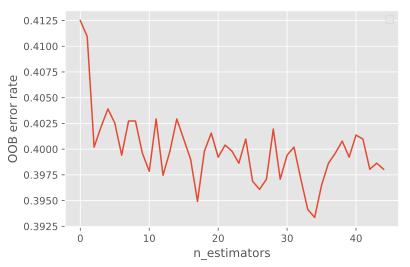

In [198]:
plt.plot(error_rate)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [200]:
np.arange(min_estimators, max_estimators, 20)[30:35]

array([700, 720, 740, 760, 780])